<a href="https://colab.research.google.com/github/zuzannasosnowska/Emotion-Recognition-for-Robots/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
file_name = "/content/fer300.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization
import os
print(os.listdir("/content/fer500"))


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

['disgust', 'happy', 'neutral', 'fear', 'sad', 'suprised', 'angry']


In [ ]:
data_path = '/content/fer500'
data_dir_list = os.listdir(data_path)

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-disgust

Loaded the images of dataset-happy

Loaded the images of dataset-neutral

Loaded the images of dataset-fear

Loaded the images of dataset-sad

Loaded the images of dataset-suprised

Loaded the images of dataset-angry



(2100, 48, 48, 3)

In [ ]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:299]=0 #300
labels[300:599]=1 #300
labels[600:899]=2 #300
labels[900:1199]=3 #300
labels[1200:1499]=4 #300
labels[1500:1799]=5 #300
labels[1800:2099]=6 #300

names = ['anger','disgust','fear','happy','neutral''sadness','surprise']

def getLabel(id):
    return ['anger','neutral','disgust','fear','happy','sadness','surprise'][id]

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

In [ ]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')
    
    return model

In [ ]:
model_custom = create_model()
model_custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)

from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=5, width_shift_range=0.05,
    height_shift_range=0.05, shear_range=0.2, 
    zoom_range=0.05,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
BS = 8
EPOCHS = 150

result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path = "/kaggle/working/weights_best_"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]

    model = create_model()
    hist = model.fit(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=0)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

In [ ]:
print(scores_acc,scores_loss)

[0.4452380836009979, 0.43809524178504944, 0.3642857074737549, 0.4452380836009979, 0.42619046568870544] [2.5434622764587402, 2.315274715423584, 2.504852533340454, 2.1572179794311523, 1.979701280593872]


In [ ]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

4


In [ ]:
model.load_weights("/kaggle/working/weights_best_"+str(value_index)+".hdf5")
best_model = model

In [ ]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)


predict_x=best_model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(predict_x)
print(classes_x)
print(y_test[0:1])

#predict
y_pred = best_model.predict(X_test)

Test Loss: 0.6653426289558411
Test accuracy: 0.7857142686843872
(1, 48, 48, 3)
[[2.2355191e-05 6.1688002e-04 2.8037513e-04 ... 3.8542778e-03
  9.2773145e-01 3.7134641e-03]
 [1.1201313e-04 2.6693037e-02 1.5631182e-02 ... 9.2108566e-01
  1.1612452e-03 2.9677637e-03]
 [2.7353793e-02 7.5703859e-03 9.1442126e-01 ... 1.3347815e-02
  1.2943469e-04 3.3528332e-02]
 ...
 [5.5685747e-01 8.0522662e-03 2.5118470e-01 ... 1.1197763e-01
  6.2540596e-05 2.5987655e-02]
 [1.0570612e-04 2.0693389e-01 7.3506758e-02 ... 9.5185428e-04
  1.0060430e-01 4.3528248e-03]
 [5.9397985e-07 1.5136003e-04 2.0619866e-03 ... 1.1030179e-03
  3.9282353e-03 3.6805647e-03]]
[5 4 2 1 1 0 3 4 0 0 2 6 5 4 3 4 4 6 0 2 6 4 4 4 0 3 2 1 0 1 3 6 2 0 6 2 0
 3 5 2 4 1 2 3 4 1 3 1 5 1 0 2 3 1 0 3 2 4 2 2 0 2 0 1 2 2 0 2 1 3 4 2 1 0
 2 0 2 1 1 0 6 5 0 6 2 2 4 2 5 5 6 2 1 0 5 6 6 6 2 5 2 4 0 0 3 2 2 4 3 2 3
 3 1 2 4 2 4 4 2 4 0 1 6 6 0 3 1 2 1 2 6 1 5 6 6 1 0 3 5 2 6 5 6 1 2 1 4 5
 1 1 5 4 5 3 0 1 3 6 1 2 5 6 5 4 6 5 4 1 4 3 1 0 5 2 4 1 

<Figure size 432x288 with 0 Axes>

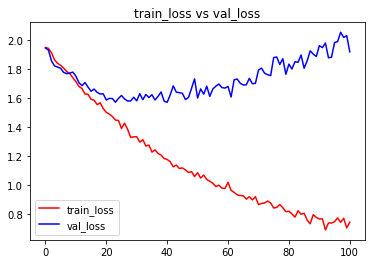

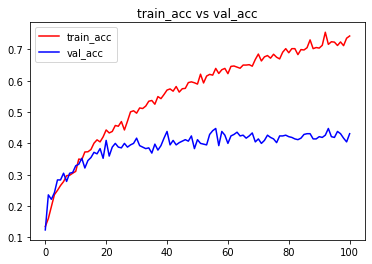

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [ ]:
from sklearn.metrics import confusion_matrix
results = classes_x
cm = confusion_matrix(np.where(y_test == 1)[1], results)

In [ ]:
import seaborn as sns
import pandas as pd

label_mapdisgust = ['anger','neutral','disgust','fear','happy','sadness','surprise']

#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )

final_cm = cm_df
final_cm

,anger,neutral,disgust,fear,happy,sadness,surprise
anger,54,3,3,0,3,0,1
neutral,0,51,3,2,1,2,1
disgust,1,6,56,1,2,1,0
fear,2,4,3,40,10,1,4
happy,0,4,4,2,49,1,2
sadness,0,1,2,3,2,39,1
surprise,5,1,3,2,3,0,41


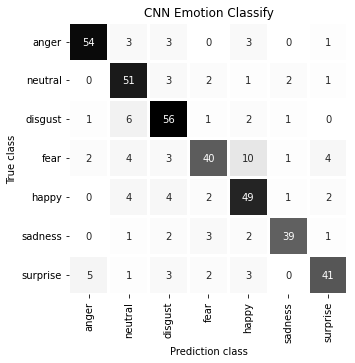

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()